# Chapter7
## Model Performance and Validation

In [3]:
import os, sys
import numpy as np
from math import floor, ceil
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
from tqdm import tqdm
import h5py
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from sample import Sample
from dataset import Dataset
from database import Database
from dataset_simulation import DatasetSimulation
from cfar_detector import CFARDetector
from nn_detector import NeuralNetworkDetector
from yolo_detector import YOLODetector
from cfar_detector_generator import CFARDetectorGenerator


dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
site = 'marion'
t_res, f_res = 0.006395061728395062, 0.15503875968992248
database = Database(dataset_loc, database_loc, site)
cfar_detector_gen = CFARDetectorGenerator(dataset_loc, database_loc, dataset_sim_loc, result_loc, site, t_res, f_res)

linewidth = 2
font_title = 32
font_legend = 20
font_label = 24
font_ticks = 18
font = [font_title, font_legend, font_label, font_ticks, linewidth] # [None]*5

files = database.get_train()

### 7.1 Defining the Benchmark

2013-05-18UT13:50:03.15432156.marion.vr2
[2.1, 2.3, 2.8]
[0.1, 2.4, 2.5]


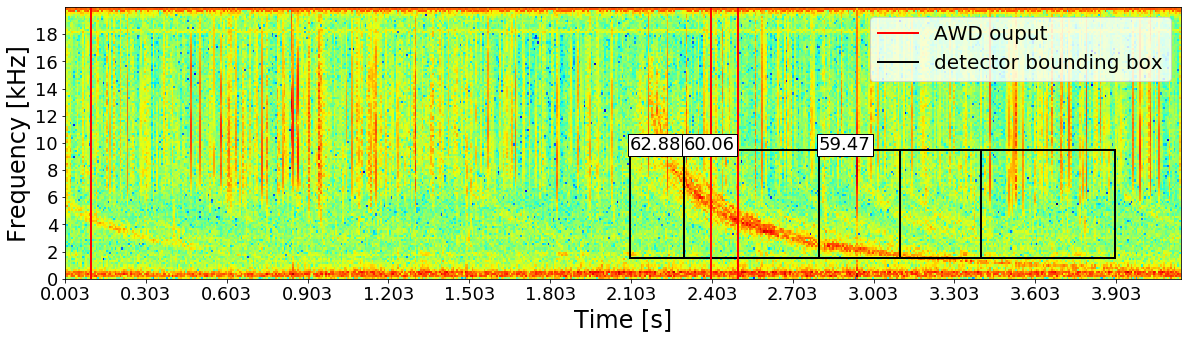

In [4]:
file = np.random.choice(files)
# file = '2013-07-19UT04:14:42.00291922.marion.vr2'
file = '2013-05-18UT13:50:03.15432156.marion.vr2'
# file = '2013-06-09UT09:29:32.01054609.marion.vr2'
sample = CFARDetector(dataset_loc, site, file)

## None
N,G,k,T1,T2,X_dB = 10,5,13,5,7,0.3
pfa = (1/(1+((10**(X_dB/10))/(2*N))))**(2*N)
transforms, transforms_params = ['slice',None,'scale'], [[1.5,9.5],[None],[0,1]]

# # Zscore [1.5,9.5]
# N,G,k,Ts,Tl,X_dB = 12,10,13,5,3,0.5
# pfa = (1/(1+((10**(X_dB/10))/(2*N))))**(2*N)
# transforms, transforms_params = ['slice','zscore','scale'], [[1.5,9.5],[None],[0,1]]

# # Zscore [4.5,11.5]
# N,G,k,Ts,Tl,X_dB = 15,7,15,2,7,0.7
# pfa = (1/(1+((10**(X_dB/10))/(2*N))))**(2*N)
# transforms, transforms_params = ['slice','zscore','scale'], [[1.5,9.5],[None],[0,1]]

# Linear Detrend [1.5,9.5]
# N,G,k,Ts,Tl,X_dB = 12,10,13,8,5,0.4
# pfa = (1/(1+((10**(X_dB/10))/(2*N))))**(2*N)
# transforms, transforms_params = ['slice','detrend','scale'], [[1.5,9.5],['linear'],[0,1]]

kernel = sample.load_kernel('sim', [0.35,80,1])
time_err = 1
print(file)
output = [o[0] for o in sample.detection_starting_locations_final(transforms,transforms_params, kernel, 'fusion_cfar', [N,G,k,T1,T2,pfa], threshold=0, time_err=time_err)]
print(output)
awd_output = [awd[0] for awd in sample.awda_whistlers(time_err=time_err)[0]]
print(awd_output)
bboxes = sample.detection_bounding_boxes(transforms,transforms_params, kernel, 'fusion_cfar', [N,G,k,T1,T2,pfa], threshold=0, time_err=time_err, duration=True)
freq_size = 4
sample.spectrogram_with_axis(log10=True)
# sample.apply_transform(['zscore'],[None])
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size)

# plt.figure(figsize=(sample.get_figsize()[0],5))
# for a in awd_output:
#     plt.axvline(a-0.2, color='r', linewidth=font[-1])
# for o in output:
#     plt.axvline(o, color='k', linewidth=font[-1])
# plt.pcolormesh(sample.get_time(),sample.get_freq(),sample.get_spectrogram(), cmap='jet')
# plt.xticks(np.arange(sample.get_time()[0], sample.get_time()[-1], .3), fontsize=font[3])
# plt.yticks(np.arange(sample.get_freq()[0], sample.get_freq()[-1], 2), fontsize=font[3])
# legend = [Line2D([0], [0], color='r', lw=font[-1], label='AWD ouput'),
#           Line2D([0], [0], color='k', lw=font[-1], label='detector ouput')]
# plt.legend(handles=legend,fontsize=font[1])
# plt.xlabel('Time [s]', fontsize=font[2])
# plt.ylabel('Frequency [kHz]', fontsize=font[2])
# plt.show()

plt.figure(figsize=(sample.get_figsize()[0],5))
for a in awd_output:
    plt.axvline(a, color='r', linewidth=font[-1])
for bbox in bboxes:
    c,x1,x2,y1,y2 = bbox
    color = 'k'
    rect = Rectangle((x1,y1), x2-x1, y2-y1, linewidth=font[-1], edgecolor=color, facecolor='none')
    plt.text(x1,y2,'%.2f'%c, fontsize=font[-2], bbox={'facecolor':'white', 'pad':2, 'ec':color})
    plt.gca().add_patch(rect)
plt.pcolormesh(sample.get_time(),sample.get_freq(),sample.get_spectrogram(), cmap='jet')
plt.xticks(np.arange(sample.get_time()[0], sample.get_time()[-1], .3), fontsize=font[3])
plt.yticks(np.arange(sample.get_freq()[0], sample.get_freq()[-1], 2), fontsize=font[3])
legend = [Line2D([0], [0], color='r', lw=font[-1], label='AWD ouput'),
          Line2D([0], [0], color='k', lw=font[-1], label='detector bounding box')]
plt.legend(handles=legend,fontsize=font[1])
plt.xlabel('Time [s]', fontsize=font[2])
plt.ylabel('Frequency [kHz]', fontsize=font[2])
plt.show()